In [1]:
import sys
import math
import re
import matplotlib.pyplot as plt
import sys
import math


interval = "1ms"
output_dir = f"./exp/fattree/interval/{interval}"
sending_rate_file = f"{output_dir}/sending-rate.txt"
pfc_file = f"{output_dir}/pfc.txt"
sender_ecn_file = f"{output_dir}/sender_ecn.txt"
switch_mark_ecn_file = f"{output_dir}/switch_mark_ecn.txt"

start_time = 2000000000

def extract_numer(exp):
    res = re.findall(r"\d", exp)
    res = "".join([str(e) for e in res])
    return res

In [15]:
""" 
###################### sending rate ######################
"""
sending_rate = {} # {node_id: {qp: {port: {time: rate}}}}
qpkey_to_id = {}
with open(sending_rate_file) as srf:
    for i, line in enumerate(srf):
        line_str = line.split()
        # print(line_str)
        ts = int(line_str[0]) - start_time
        node_id = int(line_str[1])
        qp_key = int(line_str[2])
        port = int(line_str[3])
        rate = float(line_str[4]) / float(1000000000);
        
        if node_id not in qpkey_to_id:
            qpkey_to_id[node_id] = {}
        if qp_key not in qpkey_to_id[node_id]:
            idx = len(qpkey_to_id[node_id])
            qpkey_to_id[node_id][qp_key] = idx
        qp_key = qpkey_to_id[node_id][qp_key]
        
        if node_id not in sending_rate:
            sending_rate[node_id] = {}
        if qp_key not in sending_rate[node_id]:
            sending_rate[node_id][qp_key] = {}
        if port not in sending_rate[node_id][qp_key]:
            sending_rate[node_id][qp_key][port] = {}
        sending_rate[node_id][qp_key][port][ts] = rate        
        
"""  
###################### PFC ######################
"""
pfc = {} # {node_id: {port: {ts: pause/resume}}}
with open(pfc_file) as pfcf:
    for i, line in enumerate(pfcf):
        line_str = line.split()
        ts = int(extract_numer(line_str[1])) - start_time
        node_id = int(extract_numer(line_str[3]))
        port = int(extract_numer(line_str[7]))
        pfc_type = int(extract_numer(line_str[9]))
        # print(ts, node_id, port, pfc_type)
        if node_id not in pfc:
            pfc[node_id] = {}
        if port not in pfc[node_id]:
            pfc[node_id][port] = {}
        pfc[node_id][port][ts] = pfc_type

""" 
###################### get sender receives ecn ######################
"""
sender_ecn = {} # {sender_id: {qp_key: [time]}}
with open(sending_rate_file) as srf:
    for i, line in enumerate(srf):
        line_str = line.split()
        # print(line_str)
        # break
    
        ts = int(line_str[0]) - start_time
        node_id = int(line_str[1])
        # sender_id = int(line_str[2])
        qp_key = int(line_str[2])
        qp_key = qpkey_to_id[node_id][qp_key]
        port = int(line_str[3])
        assert(port==1)
        
        if node_id not in sender_ecn:
            sender_ecn[node_id] = {}
        if qp_key not in sender_ecn[node_id]:
            sender_ecn[node_id][qp_key] = []
        sender_ecn[node_id][qp_key].append(ts)   
        
""" 
###################### accumulated pfc ######################
"""       
accumulated_pause_time = {}
for node_id in pfc:
    if node_id not in [0,1,2,5,6,7,14,15]:
        continue
    accumulated_pause_time[node_id] = {}
    for port in pfc[node_id]:
        accumulated_pause_time[node_id][port] = {}
        accum = 0
        last_pause = 0
        for tx, pause_resume in pfc[node_id][port].items():
            if pause_resume == 1:
                accumulated_pause_time[node_id][port][tx] = accum
                last_pause = tx
            else:
                accum += (tx - last_pause)
                accumulated_pause_time[node_id][port][tx] = accum

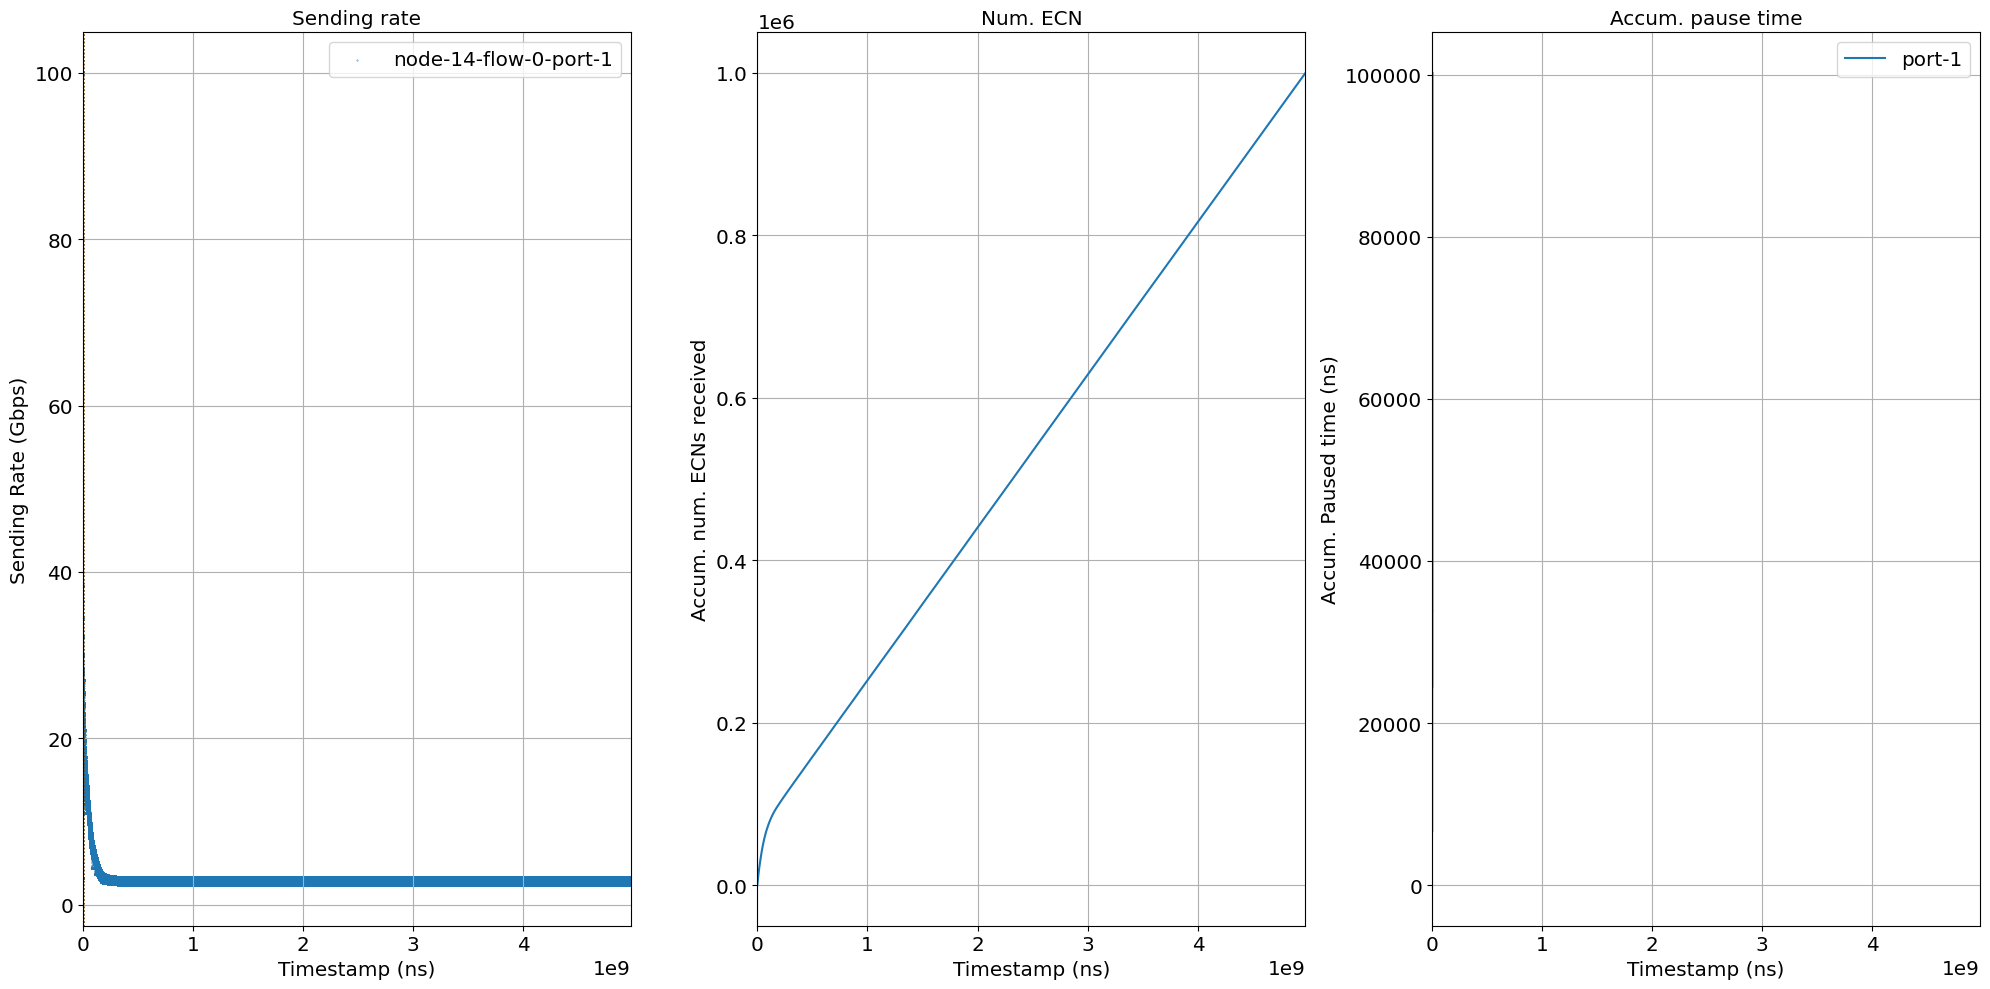

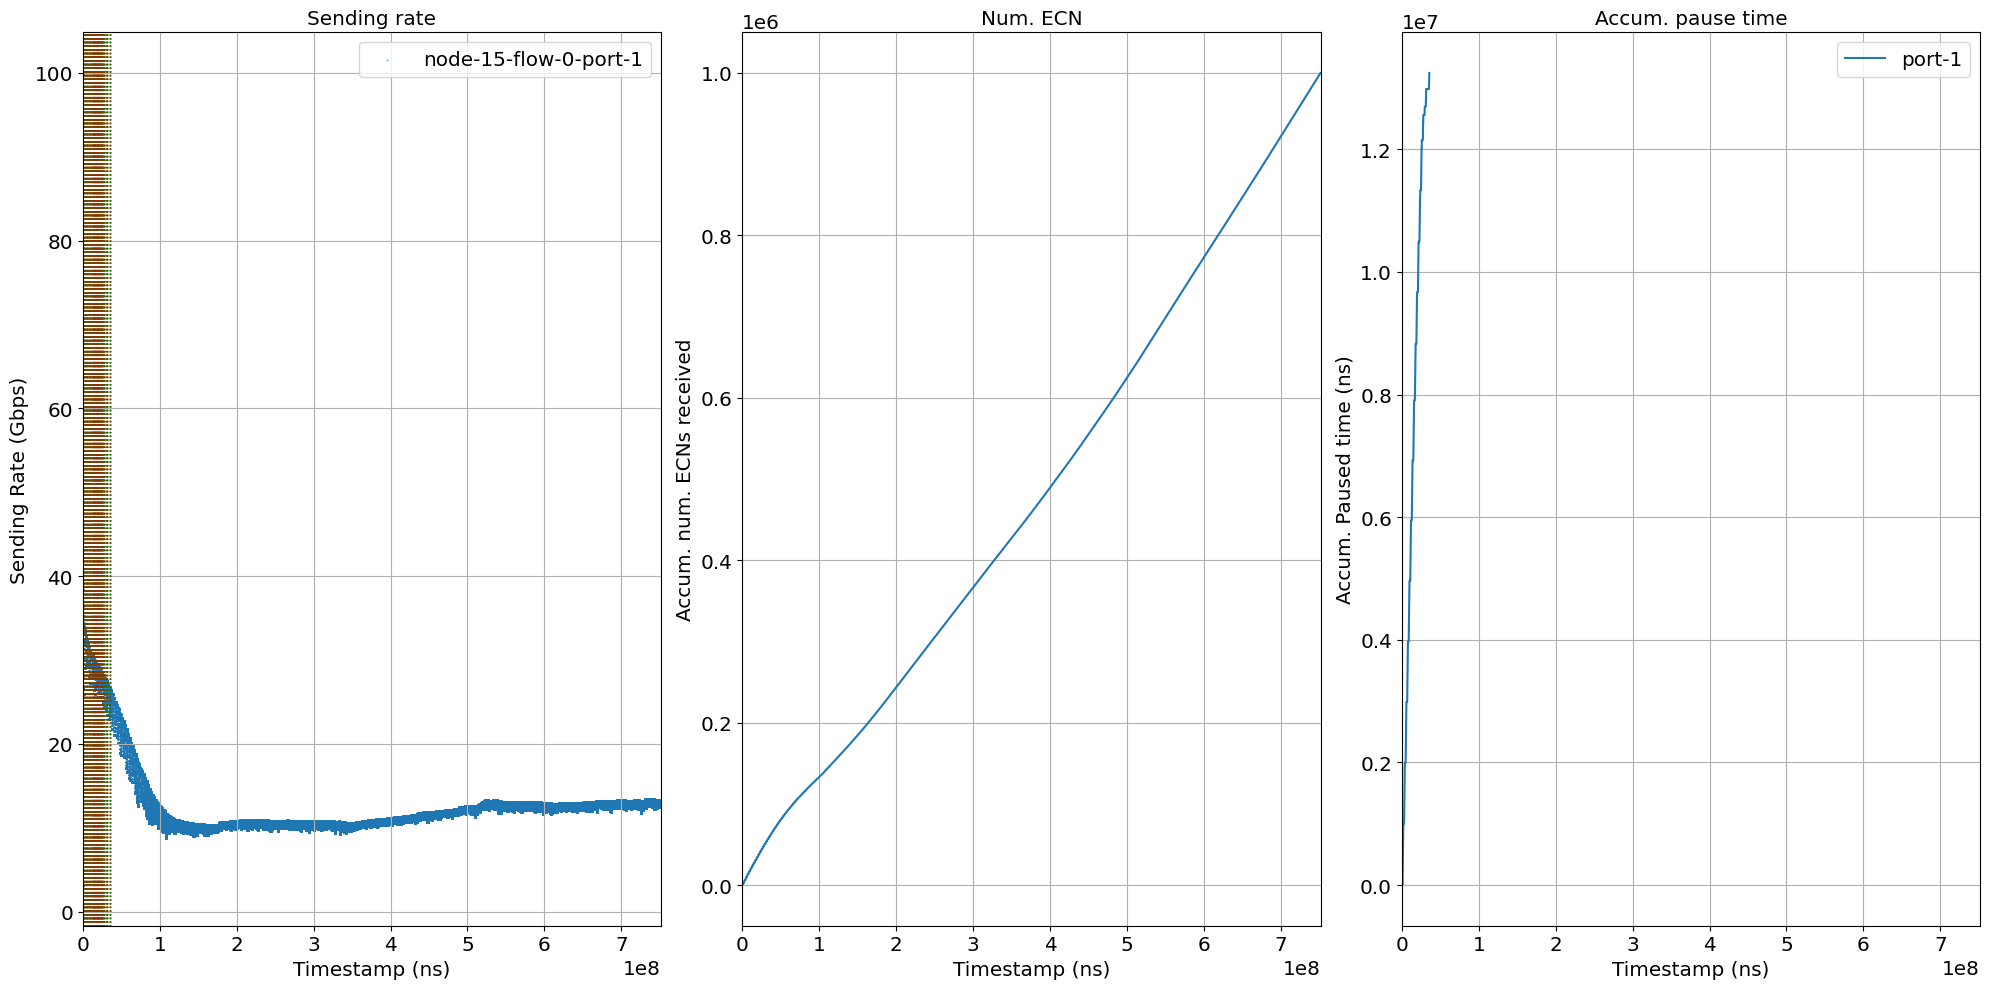

In [25]:
# per sender sending rate, pfc, ecn
for node_to_plot in [14, 15]:
    fig, ax = plt.subplots(1, 3, figsize=(20,10))
    for idx, node_id in enumerate(sending_rate.keys()):
        if node_id != node_to_plot:
            continue
        for qp_key in sending_rate[node_id]:
            assert(len(sending_rate[node_id][qp_key])) == 1
            port = 1
            
            # sending rate
            x = list(sending_rate[node_id][qp_key][port].keys())
            y = list(sending_rate[node_id][qp_key][port].values())
            ax[0].scatter(x, y, label = f"node-{node_id}-flow-{qp_key}-port-{port}", s=0.1)
            ax[0].set_title(f'Sending rate')
            ax[0].set_xlabel("Timestamp (ns)")
            ax[0].set_ylabel("Sending Rate (Gbps)")
            x_max = max(x)
            ax[0].set_xlim([0, x_max])
            ax[0].grid()
            ax[0].legend(loc="upper right")
            
            # receive pfc
            for tx, pause_resume in pfc[node_id][port].items():
                ax[0].axvline(x=tx, color='red' if pause_resume == 1 else 'green', ls=':', lw=1)        
            
            # ecn
            x = sender_ecn[node_id][qp_key]
            y = [i+1 for i in range(len(x))]
            ax[1].plot(x, y, label = f"node-{node_id}-flow-{qp_key}-port-{port}")
            ax[1].set_xlim([0, x_max])
            ax[1].grid()
            ax[1].set_title(f'Num. ECN')
            ax[1].set_xlabel("Timestamp (ns)")
            ax[1].set_ylabel("Accum. num. ECNs received")
            
            # pfc
            x = list(accumulated_pause_time[node_id][port].keys())
            y = list(accumulated_pause_time[node_id][port].values())
            ax[2].plot(x, y, label=f"port-{port}")
            ax[2].set_xlim([0, x_max])
            ax[2].set_title(f'Accum. pause time')
            ax[2].set_xlabel("Timestamp (ns)")
            ax[2].set_ylabel("Accum. Paused time (ns)")
            ax[2].grid()
            ax[2].legend()

    import matplotlib.pylab as pylab
    params = {'legend.fontsize': 'x-large',
            #   'figure.figsize': (15, 10),
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    # plt.grid()
    plt.tight_layout()
    # plt.legend() 
    # plt.show()
    plt.savefig(f"{output_dir}/node-{node_to_plot}.png")

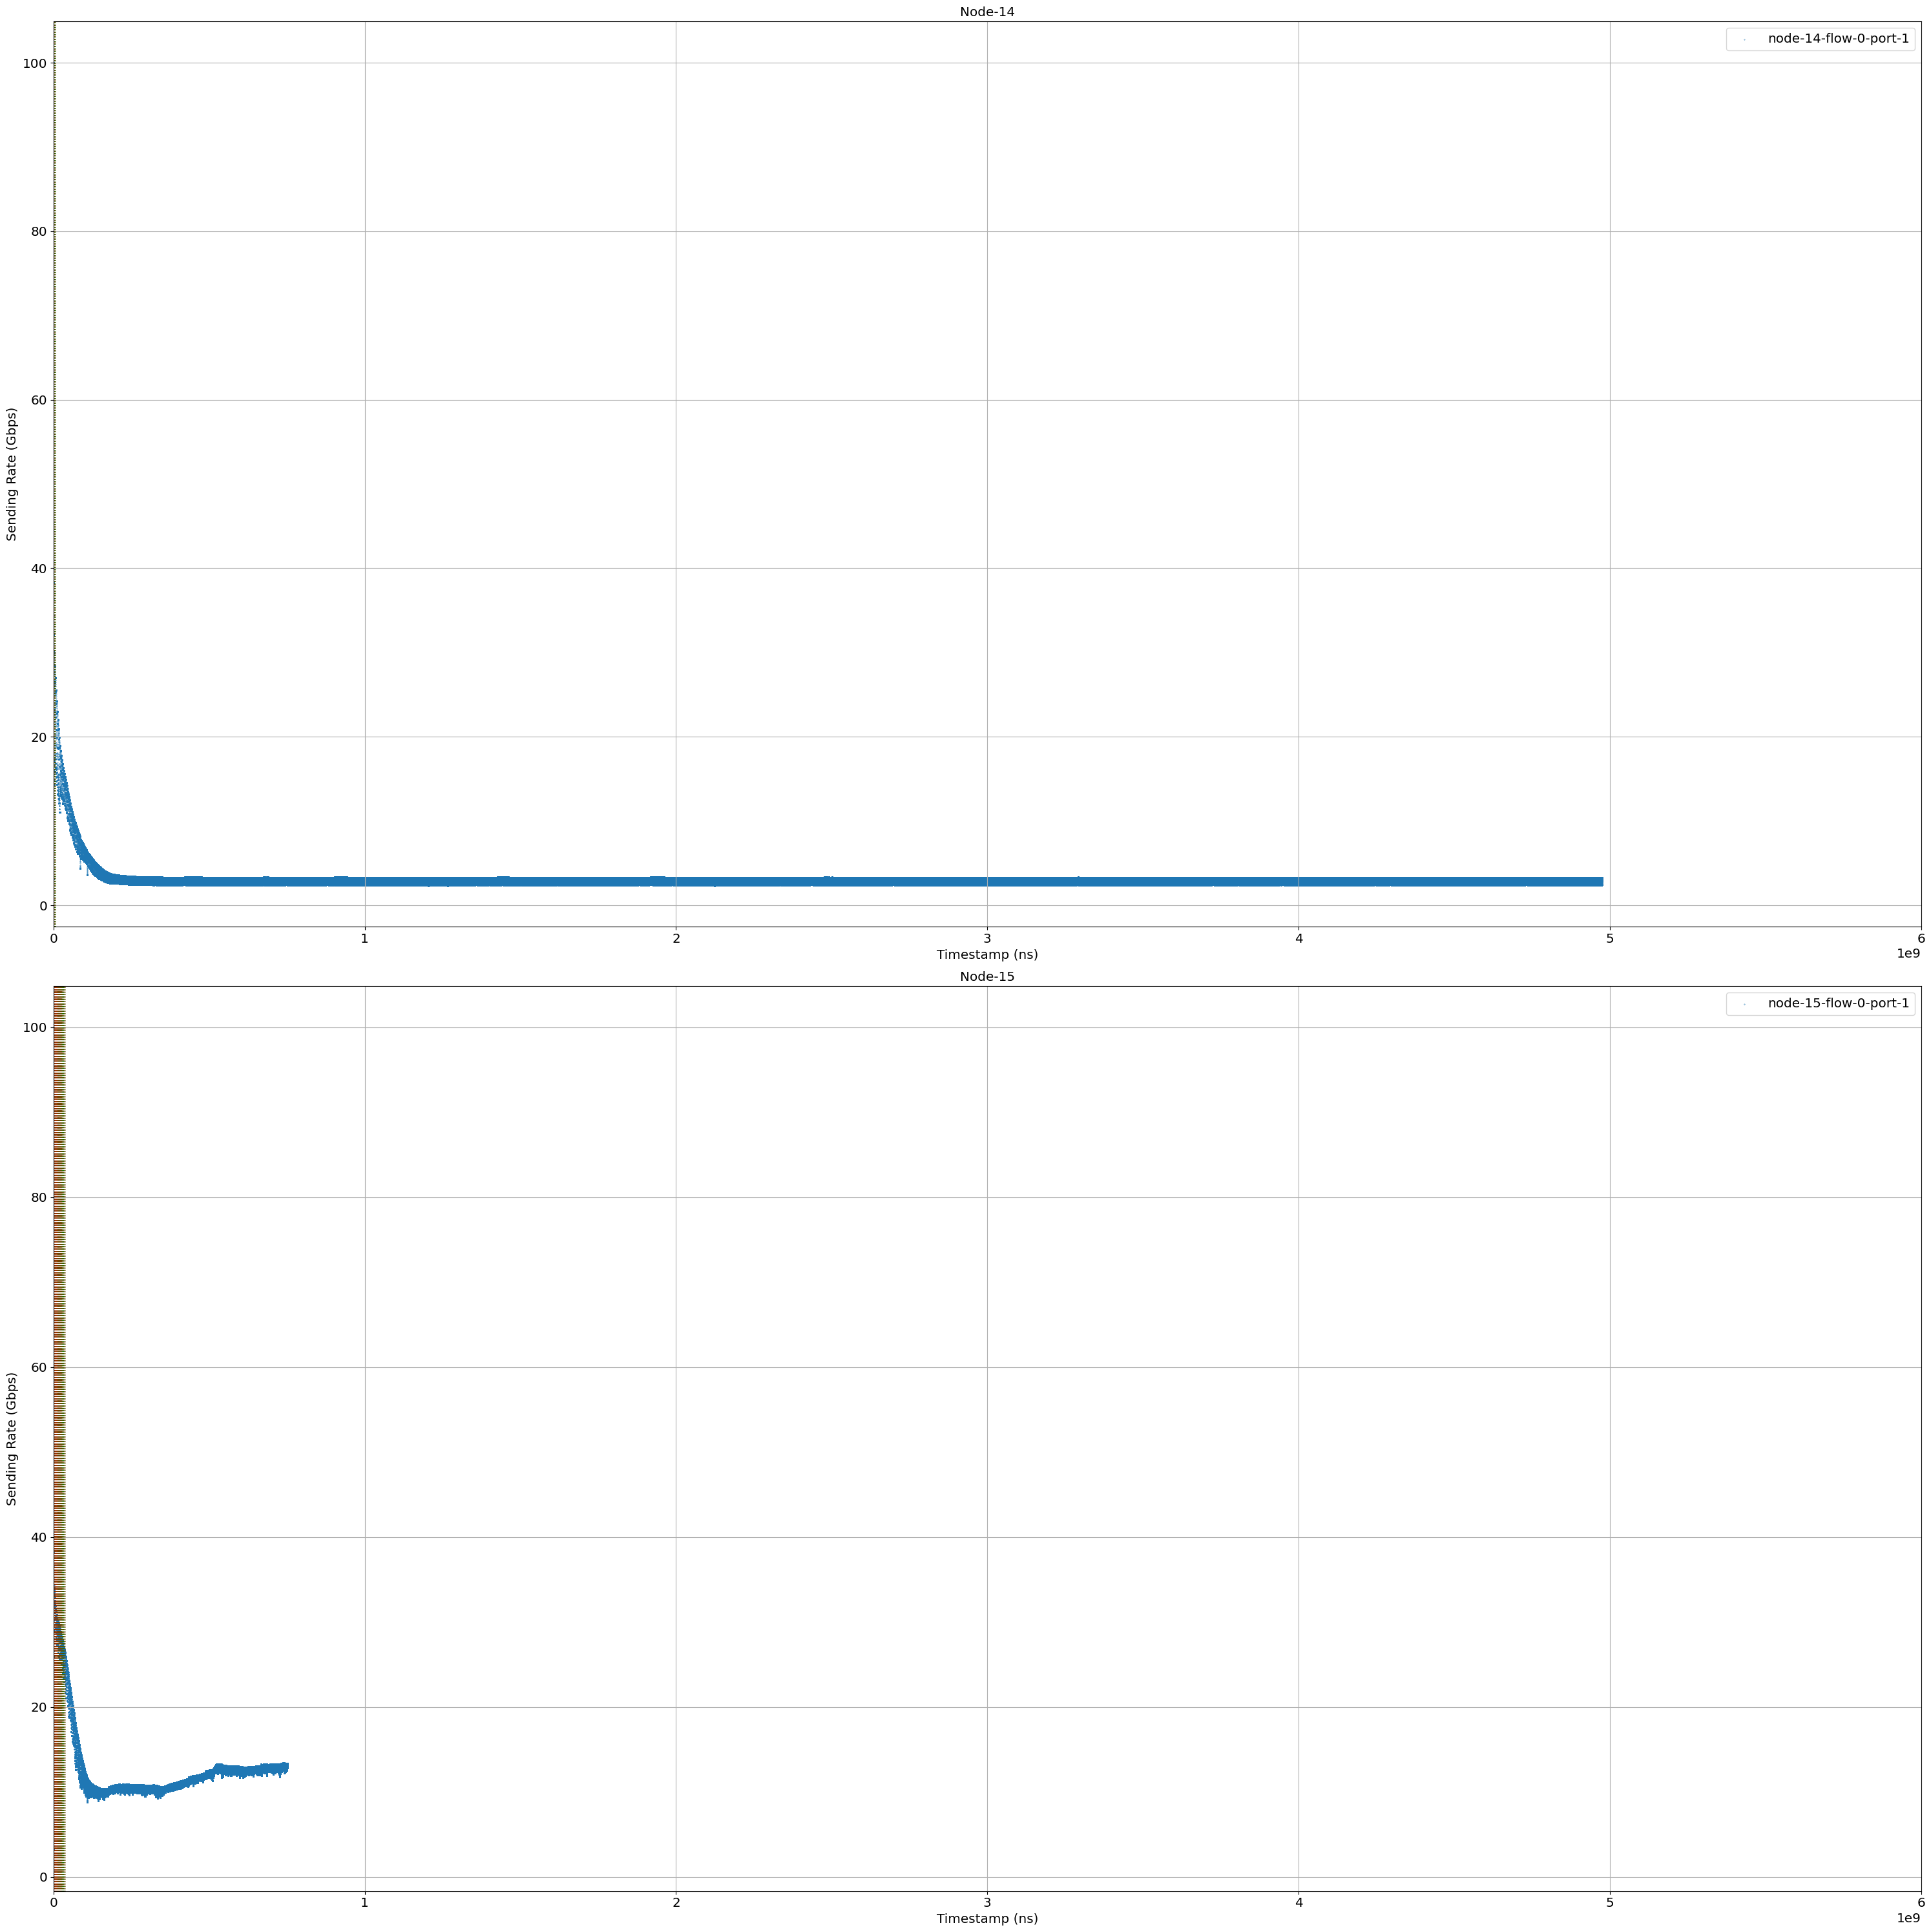

In [10]:
# sending rate
nodes_to_plot = [14, 15]
fig, ax = plt.subplots(len(nodes_to_plot), figsize=(30, 30))
# fig, ax = plt.subplots(len(nodes_to_plot))


for idx, node_id in enumerate(sending_rate.keys()):
    if node_id not in nodes_to_plot:
        continue
    for qp_key in sending_rate[node_id]:
        assert(len(sending_rate[node_id][qp_key])) == 1
        port = 1
        x = list(sending_rate[node_id][qp_key][port].keys())
        y = list(sending_rate[node_id][qp_key][port].values())
        # x = [tx for tx, rate in sending_rate[node_id][qp_key][port].items() if tx <= 1e8]
        # y = [rate for tx, rate in sending_rate[node_id][qp_key][port].items() if tx <= 1e8]

        # num_pts = math.inf
        # num_pts = min(num_pts, len(x))
        # x = x[:num_pts]
        # y = y[:num_pts]
        ax[idx].scatter(x, y, label = f"node-{node_id}-flow-{qp_key}-port-{port}", s=0.1) 

        
        if node_id in pfc and port in pfc[node_id]:
            pfc_node_port = pfc[node_id][port]
            for tx, pause_resume in pfc[node_id][port].items():
                # print(tx, "pause" if pause_resume==1 else "resume")
                ax[idx].axvline(x=tx, color='red' if pause_resume == 1 else 'green', ls=':', lw=1)        
                    
        ax[idx].set_title(f'Node-{node_id}')
        ax[idx].set_xlabel("Timestamp (ns)")
        ax[idx].set_ylabel("Sending Rate (Gbps)")
        ax[idx].set_xlim([0, 6 * 1e9])
        ax[idx].grid()
        ax[idx].legend(loc="upper right")
        
        
        # when the sender receives a cn
        # x = sender_ecn[node_id][qp_key]
        # y = [i+1 for i in range(len(x))]
        # ax[idx, 1].scatter(x, y, label = f"node-{node_id}-flow-{qp_key}-port-{port}", s=0.1) 
        # ax[idx, 1].set_xlim([0, 6 * 1e9])
        # ax[idx, 1].grid()
        # ax[idx, 1].legend(loc="upper right")

            
            


import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
        #   'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# plt.grid()
plt.tight_layout()
# plt.legend() 
# plt.show()
plt.savefig(f"{output_dir}/send_rate.png")

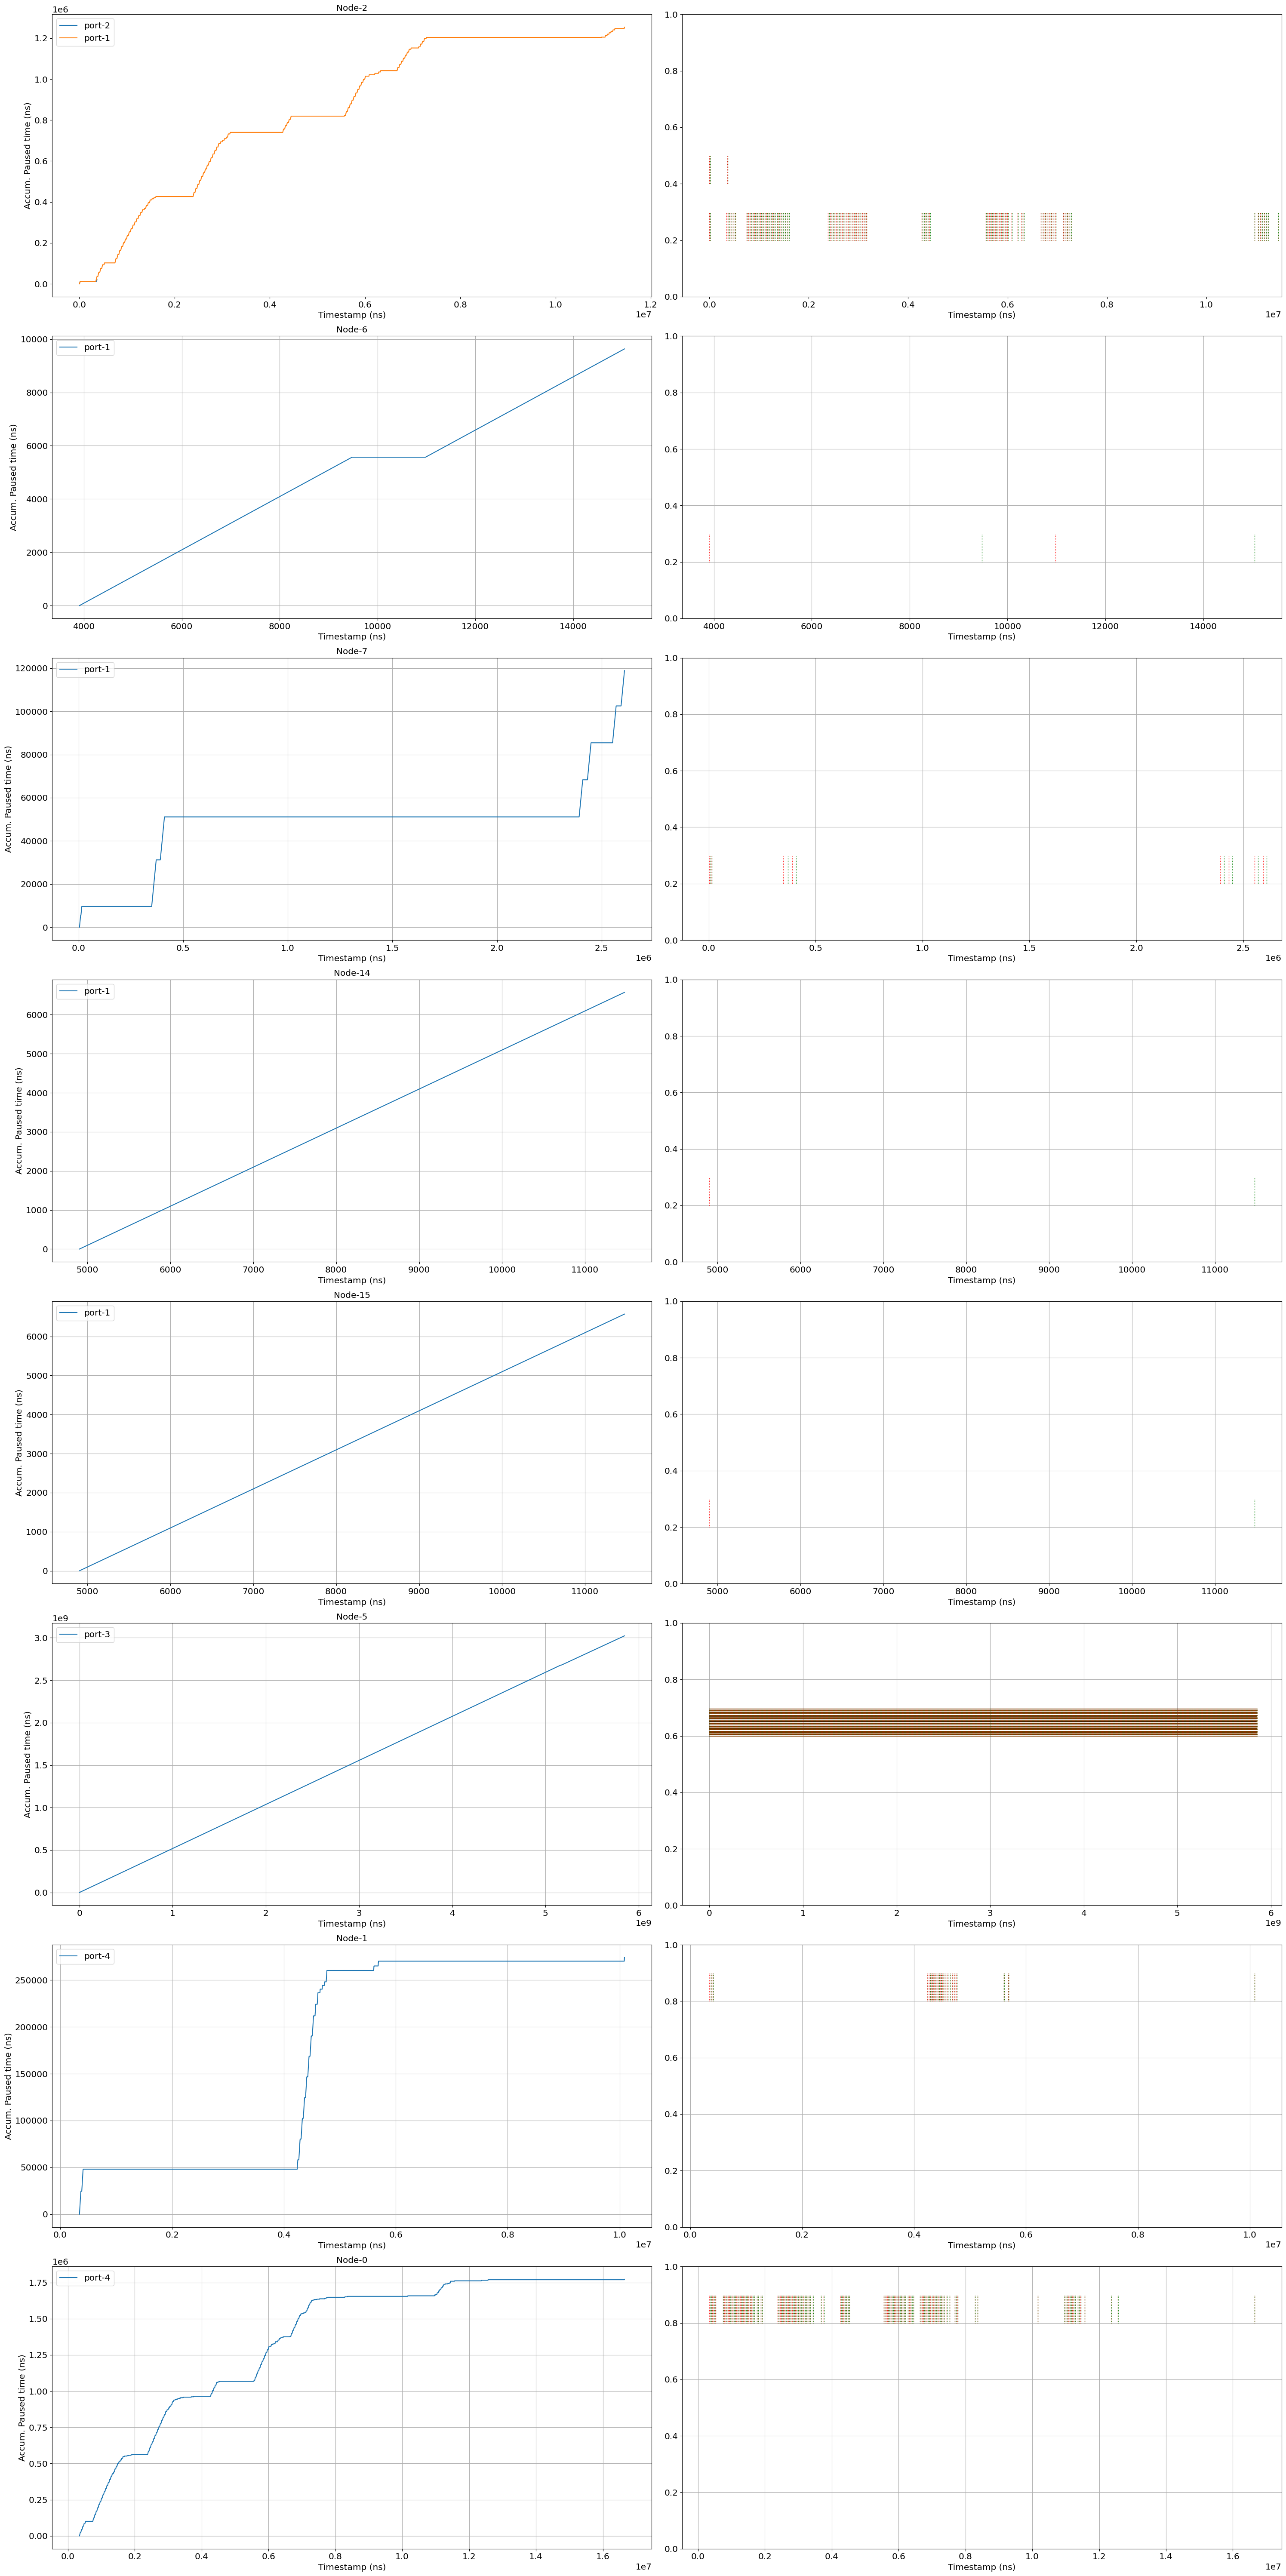

In [68]:
# accumulated pause time

# check PFC at each node, not just senders
accumulated_pause_time = {}

for node_id in pfc:
    if node_id not in [0,1,2,5,6,7,14,15]:
        continue
    accumulated_pause_time[node_id] = {}
    for port in pfc[node_id]:
        accumulated_pause_time[node_id][port] = {}
        accum = 0
        last_pause = 0
        for tx, pause_resume in pfc[node_id][port].items():
            if pause_resume == 1:
                accumulated_pause_time[node_id][port][tx] = accum
                last_pause = tx
            else:
                accum += (tx - last_pause)
                accumulated_pause_time[node_id][port][tx] = accum

fig, ax = plt.subplots(len(accumulated_pause_time), 2, figsize=(30, 60))

for idx, node_id in enumerate(accumulated_pause_time.keys()):
    
    for port in accumulated_pause_time[node_id]:
        x = list(accumulated_pause_time[node_id][port].keys())
        y = list(accumulated_pause_time[node_id][port].values())
        ax[idx,0].plot(x, y, label=f"port-{port}")
        ax[idx,0].set_title(f'Node-{node_id}')
        ax[idx,0].set_xlabel("Timestamp (ns)")
        ax[idx,0].set_ylabel("Accum. Paused time (ns)")
        ax[idx,0].grid()
        ax[idx,0].legend()
        # ax[idx,0].setsize
        
        for tx, pause_resume in pfc[node_id][port].items():
            ax[idx,1].axvline(x=tx, ymin=0.2*port, ymax=0.2*port+0.1, color='red' if pause_resume == 1 else 'green', ls=':', lw=1)
        ax[idx,1].set_xlabel("Timestamp (ns)")
        # ax[idx,1].set_ylabel("Accum. Paused time (ns)")
        ax[idx,1].grid()
        # ax[idx,0].legend()
        
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
        #   'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# plt.grid()
plt.tight_layout()
# plt.legend() 
# plt.show()
plt.savefig(f"{output_dir}/pfc.png")

In [ ]:
print(pfc[12])